In [1]:
%reset -f
import numpy as np
from landlab import RasterModelGrid
from landlab.components.overland_flow import OverlandFlow

#Mapping water depth
from landlab.plot.imshow import imshow_grid
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
colors = [(0,0,1,i) for i in np.linspace(0,1,3)]
WaterMap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

#Hillshading
from matplotlib.colors import LightSource

#Sediment Network Stuff
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels
import warnings
warnings.filterwarnings('ignore')

#Sampling a raster - coordinate
def sampleRaster(raster,x,y):
    x = int(x)
    y = int(y)
    return raster[y,x]

def TopoToNodes():
    for i in range(nNodes):
        netZ[i] = sampleRaster(np.reshape(z,(nX,nY)),netGrid.node_x[i],netGrid.node_y[i])
    
def DepthToLinks():
    for i in range(nLinks):
        tempX = netGrid.nodes_at_link[i,0]
        tempY = netGrid.nodes_at_link[i,1]
        netH[i] = sampleRaster(np.reshape(h,(nX,nY)),netGrid.node_x[tempX],netGrid.node_y[tempY])


In [2]:
#Define grid
nX = 100
nY = 100
spacing = 1.0
grid = RasterModelGrid((nX, nY), xy_spacing=1.)

## Topography ##
Datum = 500 
z = np.ones(nX*nY) * Datum
z = grid.add_field('topographic__elevation', z, at='node')

# Long. slope
Long_Slope = 1./1000
z += grid.node_y*Long_Slope
#imshow_grid(grid,'topographic__elevation')

In [3]:
# Channel Indentation
Channel_Width = 8.
Channel_Depth = 2.

isChannel = (grid.node_x > nX/2 - Channel_Width/2) * (grid.node_x < nX/2 + Channel_Width/2)

z[isChannel] -= Channel_Depth
#imshow_grid(grid,'topographic__elevation')

In [4]:
# Banks Slope
Transversal_Slope = 1./1000
z += np.abs(grid.node_x-(nX/2))*Transversal_Slope
#imshow_grid(grid,'topographic__elevation')

In [5]:
# Random noise
z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[10,10]),nX*nY) 
#imshow_grid(grid,'topographic__elevation')

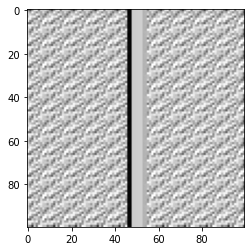

In [6]:
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(np.reshape(z,[100,100]), vert_exag=10), cmap='gray')
plt.show()

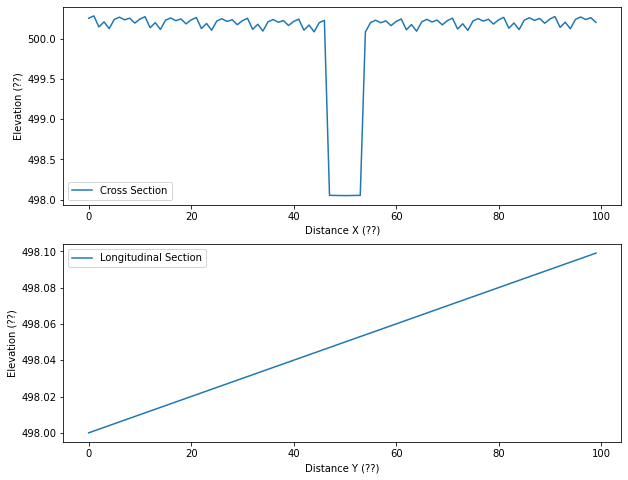

In [7]:
fig = plt.figure(figsize=(10,8))

## Cross Section
ax1 = plt.subplot(2,1,1)
ax1.plot(grid.node_x[grid.node_y==nY/2],z[grid.node_y==nY/2],label="Cross Section")
ax1.set_ylabel("Elevation (??)")
ax1.set_xlabel("Distance X (??)")
ax1.legend()

## Long Section
ax2 = plt.subplot(2,1,2)
ax2.plot(grid.node_y[grid.node_x==nX/2],z[grid.node_x==nX/2],label="Longitudinal Section")
ax2.set_ylabel("Elevation (??)")
ax2.set_xlabel("Distance Y (??)")
ax2.legend()

fig.show()

In [8]:
#Cast water depth values
#Pointer to water depth
h = np.zeros(100*100)
#bools = (grid.node_x > nX/2 - Channel_Width/2) * (grid.node_x < nX/2 + Channel_Width/2) * (grid.node_y >= 95)
bools = (grid.node_x > nX/2 - Channel_Width*2) * (grid.node_x < nX/2 + Channel_Width*2) * (grid.node_y >= 95)
h[bools] = Channel_Depth*1.1

#bools = (grid.node_x < 20) * (grid.node_y > 85) * (grid.node_y < 99)
#h[bools] = Channel_Depth*2
h = grid.add_field('surface_water__depth', h, at='node')

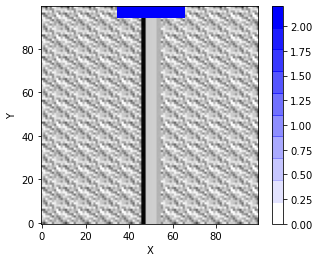

In [9]:
fig = plt.figure(figsize=(5,4))
plt.imshow(ls.hillshade(np.reshape(z,[100,100]), vert_exag=10), cmap='gray',origin="lower")
imshow_grid(grid,'surface_water__depth',cmap=WaterMap)
fig.show()

[ 498.005  498.05   498.09 ]


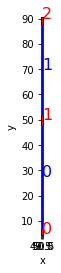

In [10]:
#Define a erosion network

#Topology
y_of_node = np.array([5,50,90])
x_of_node = np.array([50,50,50])
nodes_at_link = ((1, 0), (2, 1))

nNodes = len(x_of_node)
nLinks = len(nodes_at_link)

#Grid for sediment model
netGrid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

#Extract topograpy from raster and assign to nodes in the network
netZ = np.zeros(nNodes)
TopoToNodes()
netGrid.at_node["topographic__elevation"] = netZ
netGrid.at_node["bedrock__elevation"] = netZ - 0.5

#Print initial topographic elevation
print(netGrid.at_node["topographic__elevation"])

#Extract water depth from raster and assign it to nodes in the network
netH = np.zeros(nLinks)
DepthToLinks()
netGrid.at_link["flow_depth"] = netH

#Add other parameters :S
netGrid.at_link["reach_length"] = 50*np.ones(nLinks) # m
netGrid.at_link["channel_width"] = Channel_Width*np.ones(nLinks)

plt.figure(0)
graph.plot_graph(netGrid, at="node,link")
plt.show()

In [11]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(nLinks),30)
element_id = np.expand_dims(element_id, axis=1)

volume = 0.05*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In [12]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 
lithology = ["quartzite"] * np.size(element_id)

In [13]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

In [14]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

In [15]:
#Call flow routing
fd = FlowDirectorSteepest(netGrid, "topographic__elevation")
fd.run_one_step()

#Call sediment model
nst = NetworkSedimentTransporter(    
    netGrid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

In [16]:
#Call overland flow model
of = OverlandFlow(grid, steep_slopes=True)
of.run_one_step()

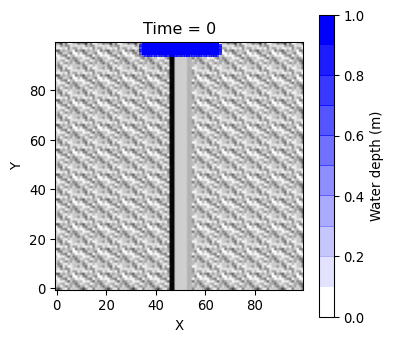

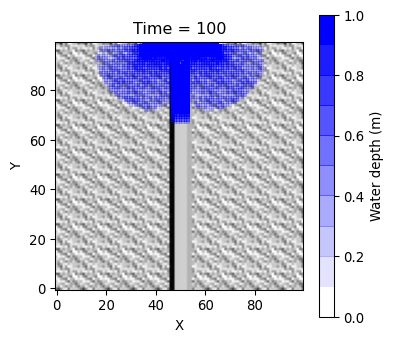

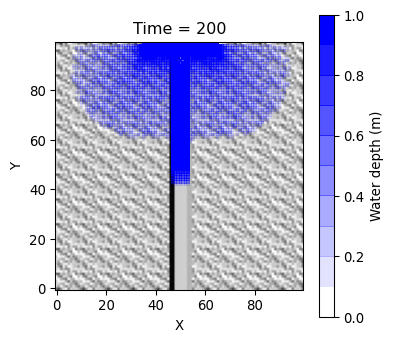

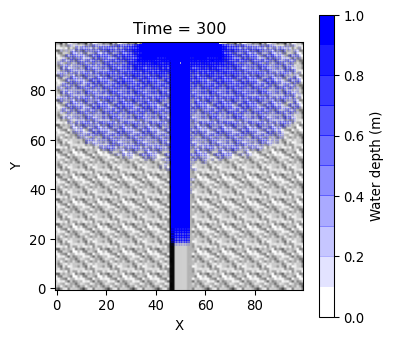

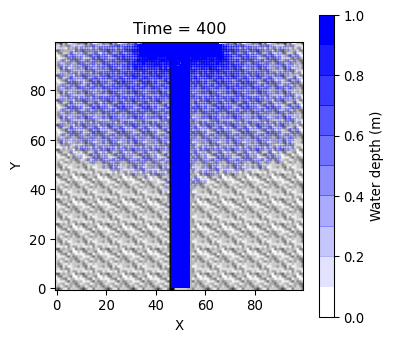

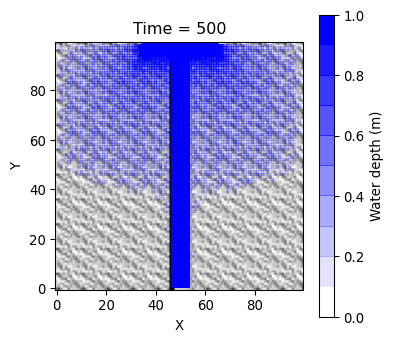

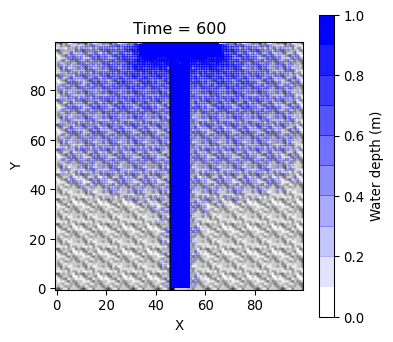

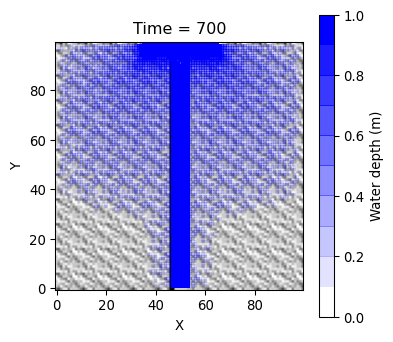

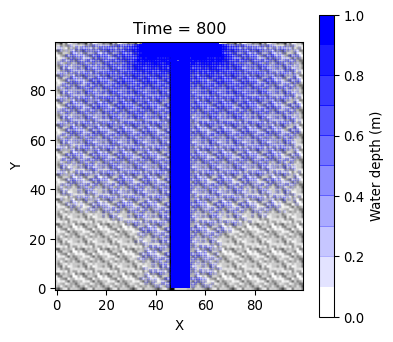

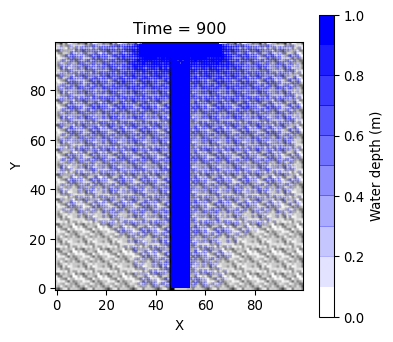

In [17]:
mydpi = 96
sizeFigure = 400

for t in range(1000):
    of.run_one_step()
#    nst.run_one_step(of.dt)
#    TopoToNodes()
#    DepthToLinks()
    
    if t%100==0:
        fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
        plt.imshow(ls.hillshade(np.reshape(z,[100,100]), vert_exag=10), cmap='gray',origin="lower")
        imshow_grid(grid,'surface_water__depth',\
                    limits=(0,1),cmap=WaterMap,\
                    colorbar_label="Water depth (m)",\
                    plot_name="Time = %i" %t)
        fig.savefig("ResultImages/" + str(t).zfill(5) + ".png")

In [18]:
import imageio
from glob import glob

In [19]:
images=[]
original_files=list(glob("./ResultImages/*.png"))
original_files.sort(reverse=False)
for file_ in original_files:
    images.append(imageio.imread(file_))
imageio.mimsave('./animation.gif', images, duration=1/5, subrectangles=True)

In [20]:
print(netGrid.at_node["topographic__elevation"])

[ 497.505  497.55   498.09 ]


In [21]:
print(netGrid.at_node)

<xarray.Dataset>
Dimensions:                      (node: 3)
Dimensions without coordinates: node
Data variables:
    topographic__elevation       (node) float64 497.5 497.6 498.1
    bedrock__elevation           (node) float64 497.5 497.6 497.6
    flow__sink_flag              (node) bool True False False
    flow__link_to_receiver_node  (node) int64 -1 0 1
    flow__receiver_node          (node) int64 0 0 1
    topographic__steepest_slope  (node) float64 0.0 0.001 0.001


In [22]:
print(netGrid.at_link)

<xarray.Dataset>
Dimensions:               (link: 2)
Dimensions without coordinates: link
Data variables:
    flow_depth            (link) float64 0.0 0.0
    reach_length          (link) float64 50.0 50.0
    channel_width         (link) float64 8.0 8.0
    flow__link_direction  (link) int8 -1 -1
    channel_slope         (link) float64 0.0009 0.0108


In [23]:
print(netGrid.at_link['flow_depth'])

[ 0.  0.]
